In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys, os, sys
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jfi import init
jaxm = init(device="cuda", dtype="float")
#jaxm = init(device="cpu", dtype="float")

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
import pmpc
from dubins_car import f_np as f_fn, fx_np as fx_fn, fu_np as fu_fn
import jaxopt
from pmpc.experimental import scp_solve
from pmpc.experimental.convex_solver import ConvexSolver
print(jaxm.zeros(()).dtype)
print(jaxm.zeros(()).device())

float32
gpu:0


In [10]:
P, q = jaxm.randn((100, 100)), jaxm.randn((100,))
P = P @ P.T

def obj_fn(x):
    J = jaxm.sum(x * (P @ x)) / 2 + jaxm.sum(q * x) + jaxm.sum(-jaxm.log(x))
    J = jaxm.where(jaxm.any(x < 0.0), jaxm.inf, J)
    return J
#print(f"best_loss = {obj_fn(jaxm.linalg.solve(P, -q))}")

In [11]:
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="binary_search", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")
print()
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="scan", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")

(Array(8.05947, dtype=float32), Array(2440.24, dtype=float32))
(Array(5.15015, dtype=float32), Array(732.3635, dtype=float32))
(Array(3.5056236, dtype=float32), Array(335.29523, dtype=float32))
(Array(2.8681705, dtype=float32), Array(252.59161, dtype=float32))
(Array(2.402569, dtype=float32), Array(231.86932, dtype=float32))
(Array(2.4269574, dtype=float32), Array(231.77573, dtype=float32))
(Array(2.427414, dtype=float32), Array(231.77567, dtype=float32))
(Array(2.427414, dtype=float32), Array(231.77567, dtype=float32))
(Array(2.4274144, dtype=float32), Array(231.77567, dtype=float32))
(Array(2.4274144, dtype=float32), Array(231.77567, dtype=float32))

(Array(7.7718835, dtype=float32), Array(2204.0967, dtype=float32))
(Array(6.109651, dtype=float32), Array(1192.9021, dtype=float32))
(Array(4.9080477, dtype=float32), Array(693.3349, dtype=float32))
(Array(4.078476, dtype=float32), Array(449.91736, dtype=float32))
(Array(3.5179002, dtype=float32), Array(333.6537, dtype=float32))
(Array(3

In [12]:
def f_fx_fu_fn(X_prev, U_prev):
    X_prev, U_prev = np.array(X_prev), np.array(U_prev)
    x, u, p = X_prev, U_prev, np.array([1.0, 1.0, 0.3])
    return f_fn(x, u, p), fx_fn(x, u, p), fu_fn(x, u, p)

In [21]:
M, N, xdim, udim = 400, 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u = [
    np.tile(z, (M,) + (1,) * z.ndim) for z in [Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u]
]

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=3e0, reg_u=1e0)
args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)

In [26]:
X, U, data = scp_solve(
    *args, max_it=50, res_tol=1e-12, **opts, solver_settings=dict(smooth_alpha=1e2, solver="CVX")
)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  2.142e-01 |  4.743e+01 |  1.541e+00 |  3.0e+00 |  1.0e+00 |  1.0e-01 |
| 0002 |  4.086e-01 |  2.818e-01 |  4.657e-01 |  3.0e+00 |  1.0e+00 |  1.0e+00 |
| 0003 |  5.948e-01 |  3.590e+00 |  2.416e+00 |  3.0e+00 |  1.0e+00 |  1.0e+01 |
| 0004 |  7.816e-01 |  9.597e-01 |  6.359e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0005 |  9.700e-01 |  8.013e-01 |  2.453e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0006 |  1.162e+00 |  7.700e-01 |  1.019e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0007 |  1.352e+00 |  7.557e-01 |  1.252e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0008 |  1.542e+00 |  7.470e-01 |  1.167e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0009 |  1.733e+00 |  7.416e-01 |  1.030e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0010 |  1.924e+00 |  7.380

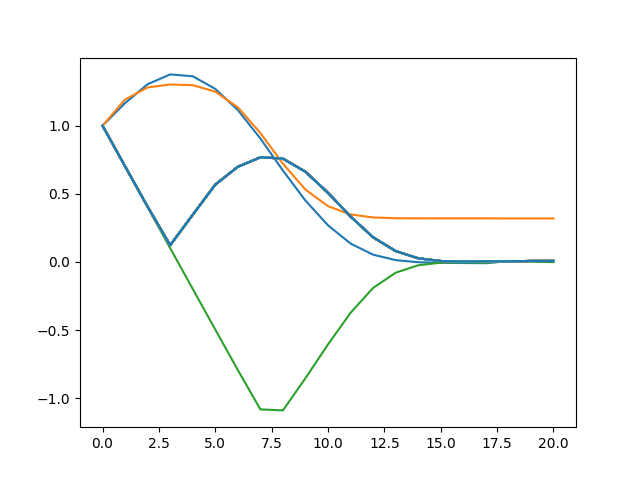

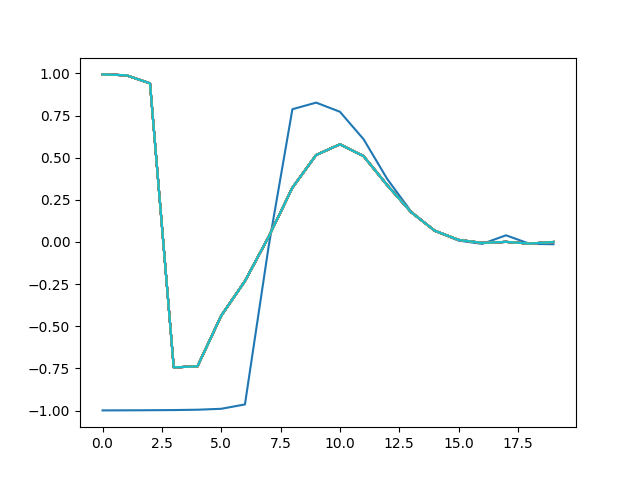

In [27]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[1]):
    plt.plot(X[idx, :, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[1]):
    plt.plot(U[idx, :, r], label=f"u{r}")
plt.show()

In [10]:
for solver in ["ecos", "osqp", "cosmo"]:
    #ret = pmpc.tune_scp(*args, **opts)
    #opts["reg_x"], opts["reg_u"] = ret
    opts["solver_settings"] = dict(solver=solver)
    X, U, data = pmpc.solve(*args, max_it=100, **opts)
    #X, U = X[0], U[0]

    #ret = pmpc.tune_scp(*args, solve_fn=pmpc.accelerated_scp_solve, **opts)
    #opts["reg_x"], opts["reg_u"] = ret
    #X, U, data = pmpc.accelerated_scp_solve(*args, max_iters=100, **opts)
    #X, U = X[0], U[0]

    plt.figure()
    plt.title(solver)
    for r in range(xdim):
        plt.plot(X[:, r], label="$x_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

    plt.figure()
    plt.title(solver)
    for r in range(udim):
        plt.plot(U[:, r], label="$u_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

plt.show()

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
